cuda
True
(60000, 784)


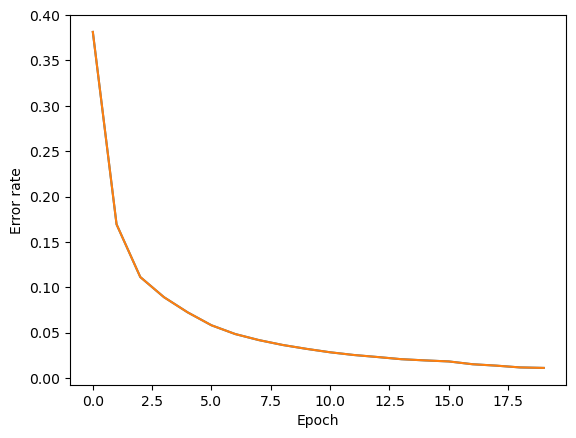

torch.Size([60000, 10])


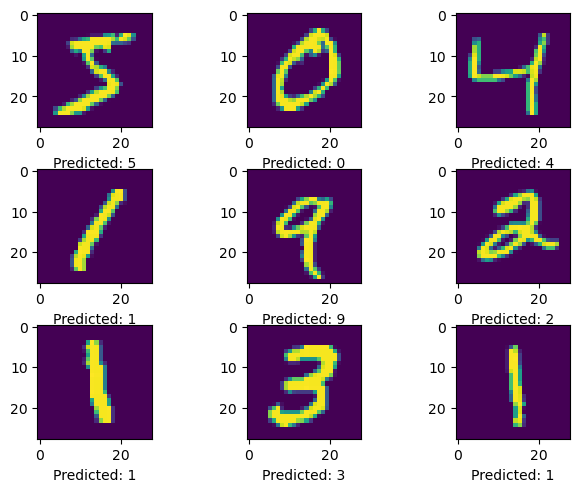

In [50]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the MNIST dataset
from torchvision.datasets import MNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Force CPU
forceCPU = False
if forceCPU:
    device=torch.device("cpu")
print(device)

dataset = MNIST(root='.', download=True)

print(torch.cuda.is_available())

# Preprocess the data
X_train = dataset.train_data.numpy().reshape((-1, 28*28)) / 255.0
X_test = dataset.test_data.numpy().reshape((-1, 28*28)) / 255.0
y_train = dataset.train_labels.numpy()
y_test = dataset.test_labels.numpy()
print(X_train.shape)

# Convert the labels to one-hot encoded vectors
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

cudaxTrain = torch.tensor(X_train, dtype=torch.float, device=device)
cudayTrain = torch.tensor(y_train, dtype=torch.float, device=device)

cudaxVal = torch.tensor(X_test, dtype=torch.float, device=device)
cudayVal = torch.tensor(y_test, dtype=torch.float, device=device)

BATCHSIZE = 10000
dataset = TensorDataset(cudaxTrain,cudayTrain)
dataloader = DataLoader(dataset=dataset, batch_size=BATCHSIZE, shuffle=True)

# Create the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Fully Connected
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 128)
        self.fc4 = torch.nn.Linear(128, 10)
    

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()
model.to(device)

# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
numEpochs = 20
history = np.zeros(shape=(numEpochs), dtype=float)
errorRate = np.zeros(shape=(numEpochs), dtype=float)
indexRange = torch.arange(cudayVal.shape[0])
indexRangeTrain = torch.arange(cudayTrain.shape[0])
# Train the model
for epoch in range(numEpochs):

    for idx, (x_batch,y_batch) in enumerate(dataloader):
        # Forward pass
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #/////////////////////

    #Forward pass
    # outputs = model(torch.tensor(X_train, dtype=float))
    # loss = loss_fn(outputs, y_batch)

    # # Backward pass
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    #///////////////////////

    #Calculate error rate
    valPred = model(cudaxVal)
    valPred = torch.argmax(valPred,dim=1)
    correct = cudayVal[indexRange,valPred]
    numCorrect = 1-(torch.sum(correct).item() / cudayVal.shape[0])

    errorRate[epoch] = numCorrect

    #Calculate error rate on training set

    valPred = model(cudaxTrain)
    valPred = torch.argmax(valPred,dim=1)
    correct = cudayTrain[indexRangeTrain,valPred]
    numCorrect = 1-(torch.sum(correct).item() / cudayTrain.shape[0])

    
    history[epoch] = numCorrect
    print("Epoch:"+str(epoch), end="\r")
    

#Plot the error rate
plt.plot(history)
plt.plot(errorRate)
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.show()

model.eval()
fig, ax = plt.subplots(3,3)
ax = ax.flatten()
fig.tight_layout(pad=0.9)

testshape = model(cudaxTrain)
print(testshape.shape)

for x in range(9):
    test = X_test[x].reshape((28,28))
    ax[x].imshow(test)
    ax[x].set_xlabel("Predicted: " + str(torch.argmax(model(torch.tensor(test.flatten(), dtype=torch.float, device=device))).item()))
    softmax = torch.nn.Softmax(dim=0)



array([0.        , 0.13873333, 0.09426667, 0.09108333, 0.0894    ,
       0.08801667, 0.08873333, 0.09153333, 0.08993333, 0.0902    ,
       0.08951667, 0.08951667, 0.08925   , 0.09086667, 0.08993333,
       0.08868333, 0.0906    , 0.09076667, 0.09      , 0.09038333])

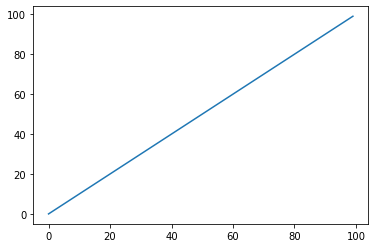

In [1]:
import numpy as np
from matplotlib import pyplot as plt

a = np.arange(100, dtype=float)
plt.plot(a)
plt.show()

In [2]:
import numpy as np
import torch
import torchvision
torch.cuda.is_available()

True